# Pancreas Basic

This tutorial shows how to apply CellRank to data to infer start/end-points of a developmental process and also how to compute a probabilistic lineage assignment for each cell. The first part of this tutorial is copied from [scVelo's tutorial on pancreatic endocrinogenesis](https://scvelo-notebooks.readthedocs.io/Pancreas.html). The data we use here comes from [Bastidas-Ponce et al. (2018)](https://dev.biologists.org/content/146/12/dev173849.abstract). 

For more info on scVelo, see the [github](https://scvelo-notebooks.readthedocs.io/index.html) or read the [preprint](https://www.biorxiv.org/content/10.1101/820936v1). 

This is the 'basic' or high level mode to interact with cellrank, which is quick and simple but does not offer as many options as the low level mode, in which you interact directly with our two main classes, `KernelExpression` and `Markov_Chain`. If you would like to get to know this more advanced way of interacting with cellrank, see the `pancreas_advanced` tutorial. 

## Import packages & data

We start by importing all required packages and data. 

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import matplotlib.cm as cm

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

In [2]:
adata = scv.datasets.pancreatic_endocrinogenesis()
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.83 0.17]


AnnData object with n_obs × n_vars = 3696 × 27998 
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

## Pre-processing

Pre-process the data and compute moments.

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


## Run scVelo

We will use the dynamical model from scVelo to estimate the velocities, this may take a while (~10min) to compute. Consider caching this computation using [scachepy](https://github.com/theislab/scachepy). The first step is to estimate the parameters of the dynamical model.

In [4]:
scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (0:09:50) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Once we have the parameters, we can use these to compute the velocities and the velocity graph. The velocity graph is a weighted graph that specifies how likely two cells are to transition into another, given their velocity vectors and relative positions. 

In [5]:
scv.tl.velocity(adata, mode='dynamical', min_r2=None)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


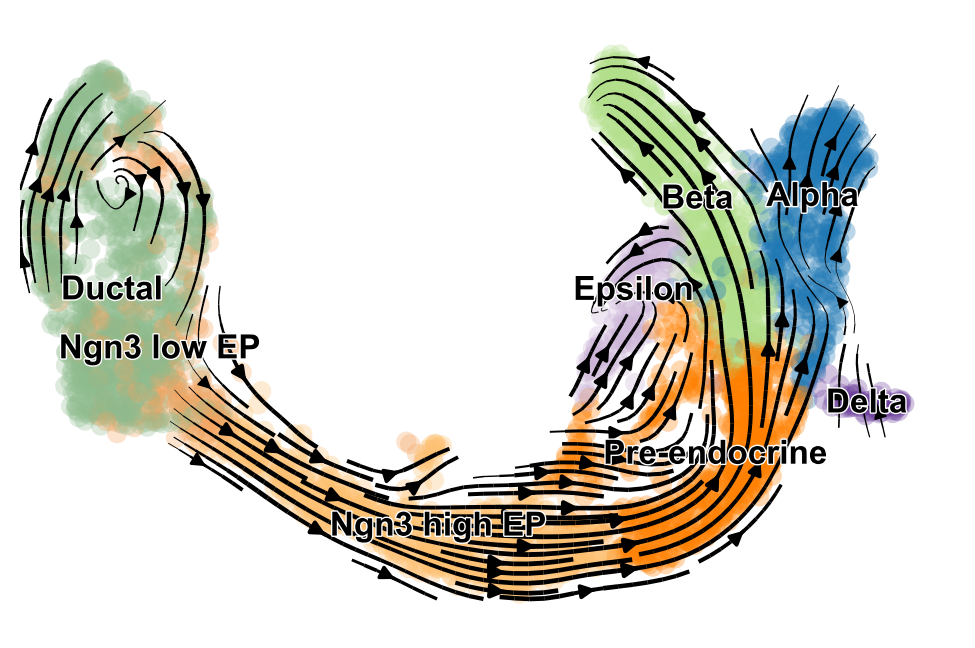

In [6]:
scv.pl.velocity_embedding_stream(adata, basis='umap', legend_fontsize=12, title='', smooth=.8, min_mass=4)

## CellRank

CellRank builds on the velocities computed by scvelo to compute start & endpoints of the developmental proces. It further uses the velocities to calculate how likely each cell is to travel towards each of the endpoints. Before we start, we recompute the velocity graph using `mode_neighbors='connectivities'`, which ensures that the resulting Markov chain is irreducible, see [wikipedia on Markov chains](https://en.wikipedia.org/wiki/Markov_chain). We also set `n_recurse_neighbors` to 0 to make sure that only first-order neirest neighbors are considered. 

In [7]:
scv.tl.velocity_graph(adata, mode_neighbors='connectivities', n_recurse_neighbors=0)

computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Final Cells

Endpoints (=final cells) can be computed by running the following command:

In [49]:
cr.tl.root_final(adata, cluster_key='clusters', percentile=96)

Computing `final_cells`
Computing transition matrix based on velocity correlations
    Finish` (0:00:00)
Computing eigendecomposition of transition matrix
Computing approximate recurrent classes
Adding `adata.uns['final_cells_colors']`
       `adata.obs['final_cells']`
       `adata.obs['final_cells_probs']`
       `.approx_rcs_colors`
       `.approx_rcs_probs`
       `.approx_rcs`
    Finish (0:00:00)
Added key `final_cells` to `adata.obs`    Finish (0:00:01)


The most important parameters in the above function are:

 - `percentile`: specifies how many percent of cells in this dataset we expect to be transient, i.e. not fully differentiated. 
 - `cluster_key`: takes a key from `adata.obs` under which cluster labels are stored, i.e. 'clusters' or 'louvain'. It then compares the set of end-point labels with the set of cluster labels to associate names and colors with the endpoints. 
 - `n_start_end`: number of expected start/endpoints. This parameter is optional - if it's not provided, this number is estimated from the so-called 'eigengap heuristic' of the spectrum of the transition matrix. 
 - `weight_connectivities`: weight given to an optional diffusion kernel. Given two cells `i` and `j` , the velocity-derived transition probabilitiy to go from `i` to `j` only depends on the angle between `i`s velocity vector and the vector that connects cells `i` and `j` in gene expression space. If one wants the transition probabilities to also depend on transcriptomic similarity of `i` and `j` in gene expression space, then giving some weight to an additive diffusion kernel is a way to do so. 

When running the above command, CellRank adds a key `final_cells` to adata.obs. This can be plotted conveniently using scvelo's scatter function:

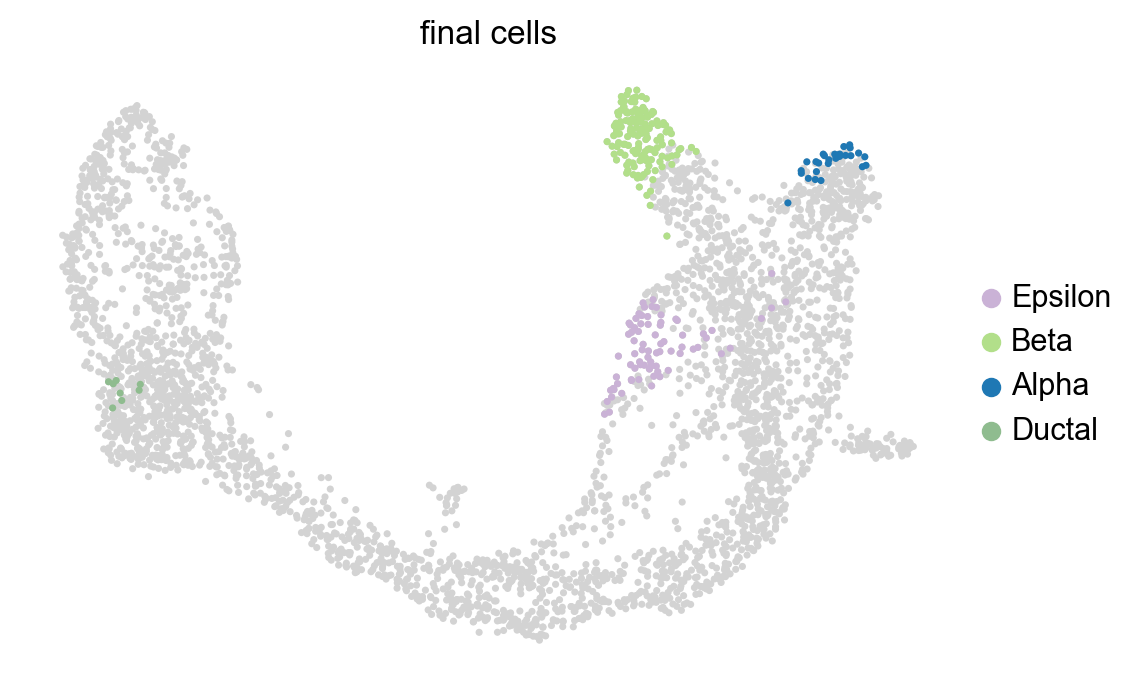

In [50]:
scv.pl.scatter(adata, color='final_cells', legend_loc='right margin')

## Lineage Probabilities

Once we know where the endpoint are, we can compute how likely each cell is to travel/develop towards each of these:

Computing lineage probabilities towards `final_cells`
Computing absorption probabilities
    Finish (0:00:00)
Added key `to_final_cells` to `adata.obsm`
    Finish (0:00:02)


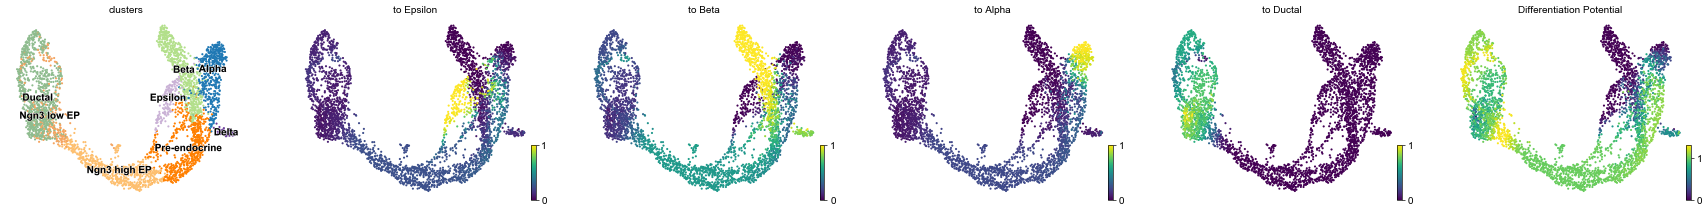

In [57]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, cluster_key='clusters', dpi=30)

These plots should be interpreted as follows: The first plot on the left is just the precomputed clustering. The following three plots "to Endpoint x" show, for every cell, how likely it is to go to that endpoint. The last plot, "Differentiation Potential", is the entropy over cell fates and therewith a measure for cell plasticity. The idea to define plasticity in this way comes from [Palantir](https://www.nature.com/articles/s41587-019-0068-4). We can aggregate these probabilities from single cells to the cluster level and plot them e.g. on a [PAGA](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.paga.html#scanpy.tl.paga) abstracted graph:

running PAGA
    finished (0:00:00)


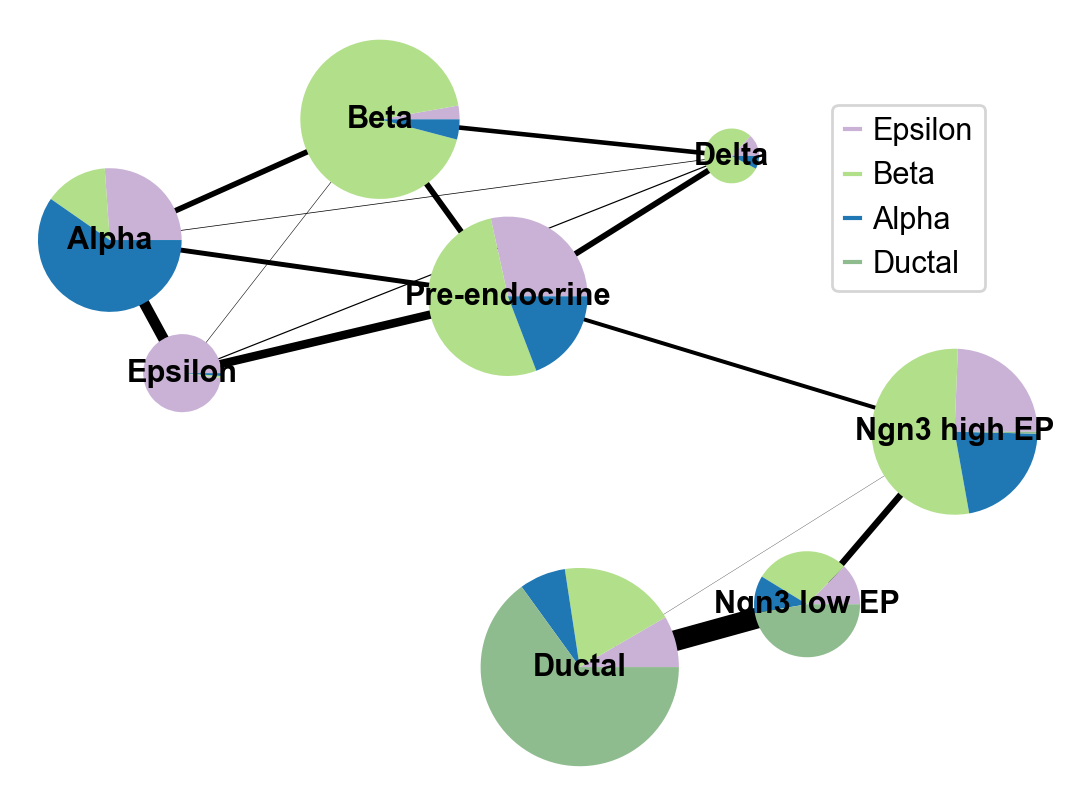

In [52]:
sc.tl.paga(adata, groups='clusters')
cr.pl.cluster_fates(adata, cluster_key='clusters', mode='paga_pie', node_size_scale=4, frameon=False)

This basically says that some ductal cells mature to become mature ductal cells, while others become endocrine. Out of the ones that become endocrine, the beta endpoint is the most likely. This makes sense biologically at E15.5 in development. 


Given the lineage probabilities, we can ask interesting questions like: how similar are clusters in therms of their endpoint probabilities (`cellrank.pl.similarity_plot`)? How does expression of a given gene vary along a specified lineage/trajectory (`cellrank.pl.gene_trends` and `cellrank.pl.heatmap`)? How plastic are different cellular subpopulations (`cellrank.pl.cluster_fates(adata, ..., mode='violin')`)?

To find out more, check out the CellRank API. 

## Root Cells

The same sort of analysis can now be repeated for the start cells by passing the keywork `final = False`:

Computing `root_cells`
Computing transition matrix based on velocity correlations
    Finish` (0:00:00)
Computing eigendecomposition of transition matrix
Computing approximate recurrent classes
Adding `adata.uns['root_cells_colors']`
       `adata.obs['root_cells']`
       `adata.obs['root_cells_probs']`
       `.approx_rcs_colors`
       `.approx_rcs_probs`
       `.approx_rcs`
    Finish (0:00:00)
Added key `root_cells` to `adata.obs`    Finish (0:00:01)


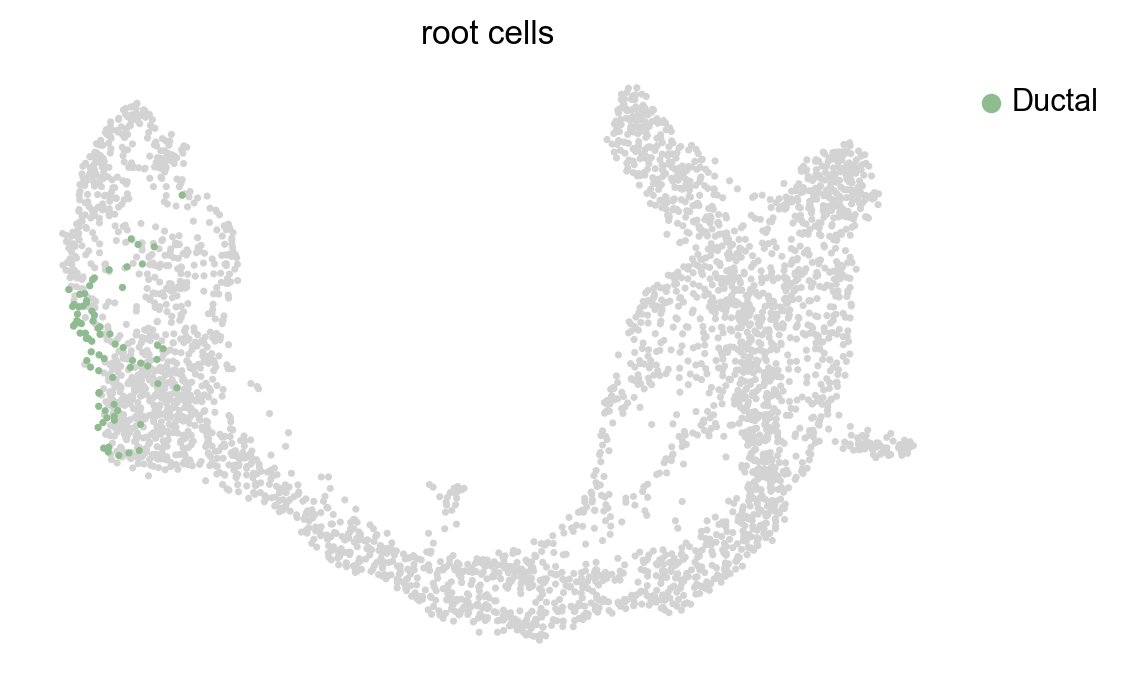

In [53]:
cr.tl.root_final(adata, cluster_key='clusters', final=False) 
scv.pl.scatter(adata, color='root_cells')

We found one group of starting cells, located in the Ductal/Ngn3 low EP cluster. 

## Gene Expression Trends

The functions demonstrated above are the main functions of cellrank: computing start & endpoints and how likely each cell is to go to each of the endpoints. We can use these probabilites now e.g. to plot gene expression trends along lineages. 

Let's start with a temporal ordering for the cells. To get this, we can compute scvelo's [latent time](https://scvelo.readthedocs.io/scvelo.tl.latent_time.html#scvelo.tl.latent_time), starting from the cellrank-computed root's by specifying the `root_key` and `end_key` parameters:

computing latent time
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


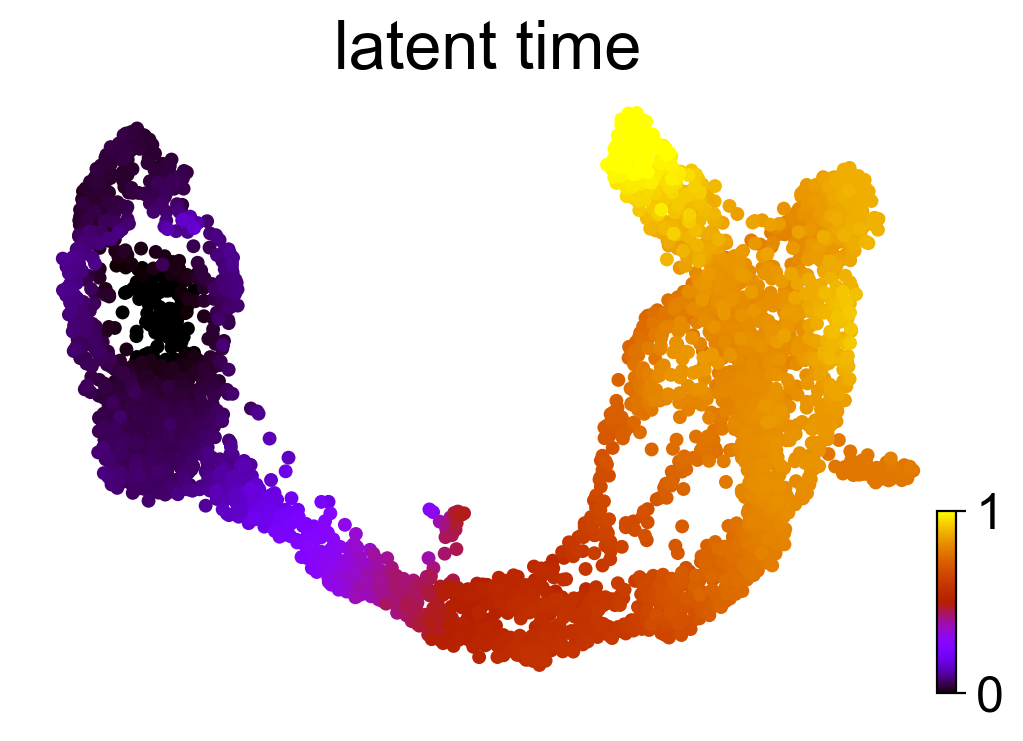

In [19]:
scv.tl.recover_latent_time(adata, root_key='root_cells', end_key='final_cells')

scv.pl.scatter(adata, color='latent_time', fontsize=24, size=100,
               color_map='gnuplot', perc=[2, 98], colorbar=True, rescale_color=[0,1])

Choose a number of genes with high model likelihood and plot them on the embedding:

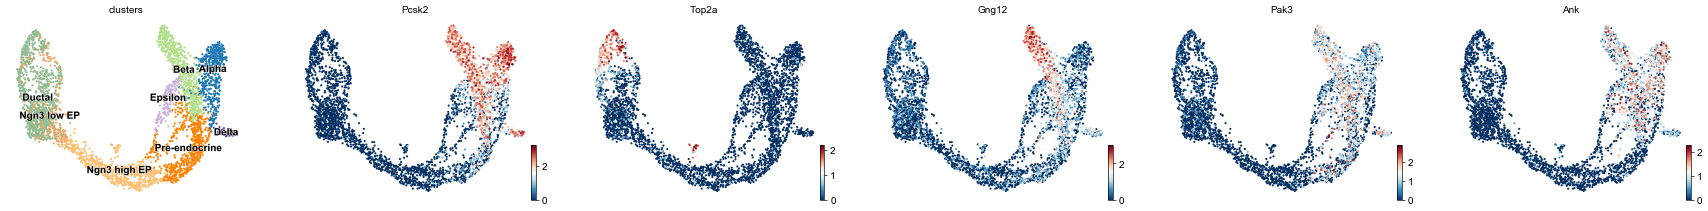

In [54]:
genes = adata.var.sort_values(by='fit_likelihood', ascending=False).head(5).index
scv.pl.scatter(adata, color=['clusters'] + list(genes), dpi=30)

We can plot dynamics of these genes in latent time towards each endpoint seperately:

Computing trends using `8` core(s)



    Finish (0:00:03)


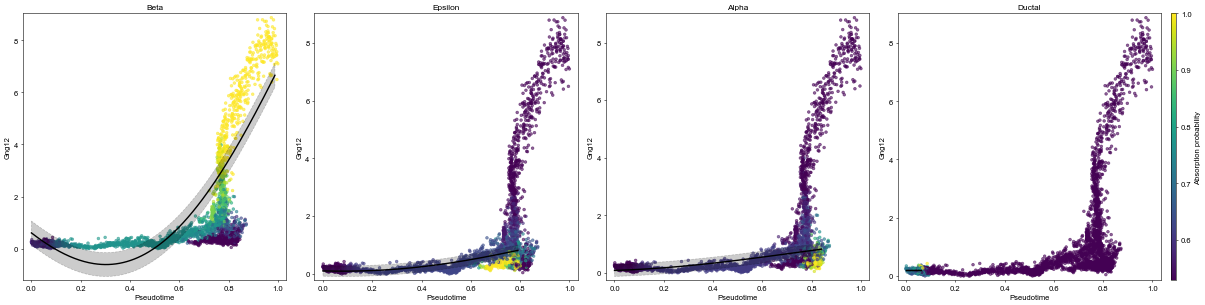

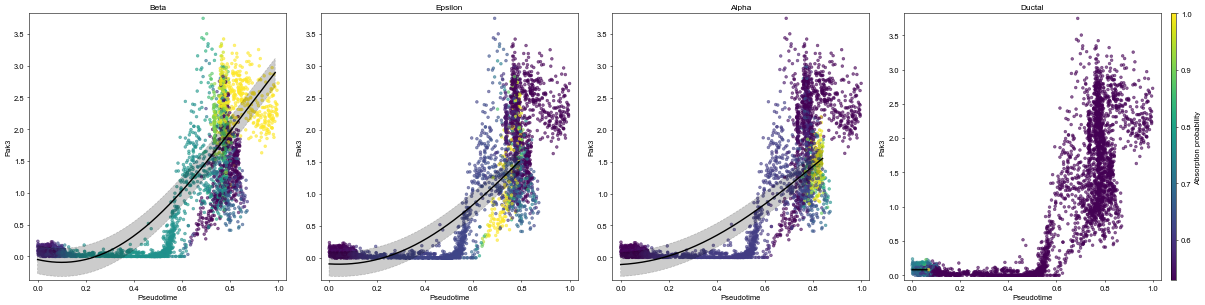

In [33]:
# model = cr.ul.models.GamMGCVModel(adata, n_splines=7, sp=100)
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
model = cr.ul.models.SKLearnModel(adata, KernelRidge(kernel=RBF()))

cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=['Gng12', 'Pak3'],
                  time_key='latent_time',
                  weight_threshold=0.05, weight_scale=1, filter_data=True, dpi=25)

This function plots all cells and colors them according to how likely they are to belong to one specific lineage. It can fit any sklearn model to the data while taking the lineage weights into account. This can also be done in the same panel, hiding the cells, to focus on the main trends:

Computing trends using `1` core(s)



    Finish (0:00:01)


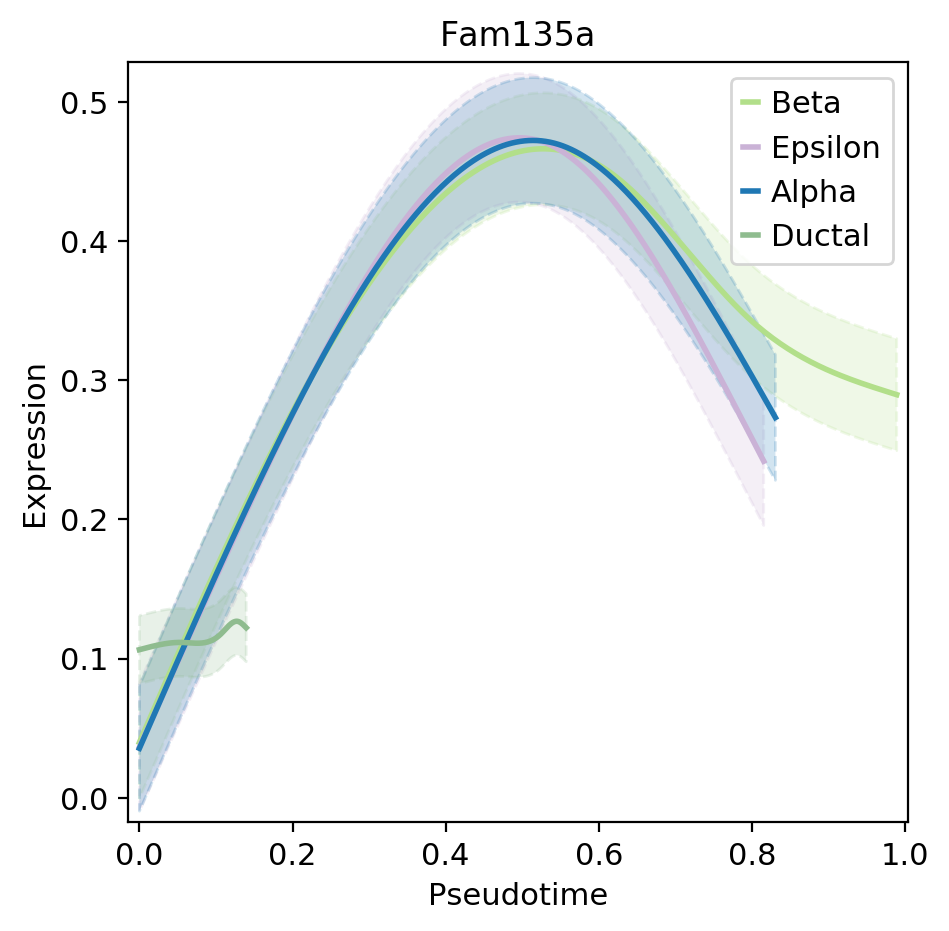

In [17]:
model = cr.ul.models.GamMGCVModel(adata, n_splines=5, sp=50)

cr.pl.gene_trends(adata, model=model, data_key='Ms',
                  genes=adata.var_names[5], ncols=1,
                  time_key='latent_time', same_plot=True, hide_cells=True, filter_data=True,
                  weight_threshold=0.05, weight_scale=1, figsize=(5, 5), n_test_points=300)

Gene expression trends can equally be visualised as heatmaps, see :func:`cellrank:pl.heatmap`. 